In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# Useful functions

In [2]:
def load_file(path):
    if os.path.exists(path):
        if path[-4:] == '.csv':
            file = pd.read_csv(path)
        else:
            with open(path, 'rb') as f:
                file = pickle.load(f)
                f.close()
        return file, True
    else:
        return None, False

# Optimizaion versus greedy expansion

In [3]:
# calculate current job accessibility
args, _ = load_file('/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/MaxANDP/prob/trt/args_adj_ratio.pkl')
conn_pairs, _ = load_file('/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/MaxANDP/data/trt_instance/od_pairs_conn.pkl')
conn_pairs = [(orig, des) for orig in conn_pairs for des in conn_pairs[orig]]
pop = args['job']
curr_acc = np.sum([pop[des] for _, des in conn_pairs])

In [4]:
def get_greedy(budgets):
    df = pd.read_csv('/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/MaxANDP/prob/trt/res/job/greedy_abs_job_par.csv')
    records = []
    for b in budgets:
        records.append(df[df['allocated'] <= b * 4]['acc'].values[-1])
    return records

In [5]:
def get_opt(budgets, sidx=0, eidx=20, p=500):
    records = np.zeros(len(budgets))
    for idx in range(sidx, eidx + 1):
        path = '/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/MaxANDP/prob/trt/res/job/summary/efficiency-n{}_id{}_summary.csv'.format(p, idx)
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path)
        df = df.sort_values(by = 'budget')
        acc = []
        for j, b in enumerate(budgets):
            vals = df[df['budget'] <= b * 4]['job_acc'].values
            if len(vals) > 0:
                acc.append(np.max(vals))
            else:
                acc.append(0)
        records = np.maximum(records, acc)
    records = [np.max(records[:idx + 1]) for idx in range(len(records))]
    return records

In [6]:
def get_opt_factor(budgets, sidx=0, eidx=20, p=500, f=1):
    records = []
    for j, b in enumerate(budgets):
        l = int((eidx - sidx + 1) * j / 10 * f) + 3 if j <= 2 else int((eidx - sidx + 1) * j / 10 * f)
        val = 0
        for idx in range(sidx, sidx + l):
            path = '/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/MaxANDP/prob/trt/res/job/summary/efficiency-n{}_id{}_summary.csv'.format(p, idx)
            if not os.path.exists(path):
                continue
            df = pd.read_csv(path)
            df = df.sort_values(by = 'budget')
            vals = df[df['budget'] <= b * 4]['job_acc'].values
            max_val = np.max(vals)
            if len(vals) > 0:
                val = np.max([val, max_val])
        records.append(val)
    records = [np.max(records[:idx + 1]) for idx in range(len(records))]
    return records

In [9]:
def greedy_opt(sidx, eidx, p, budgets):
    # init figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # load reocrds
    greedy_acc = get_greedy(budgets) / curr_acc * 100
    acc1 = get_opt_factor(budgets, sidx=21, eidx=42, p=2000, f=1/3) / curr_acc * 100
    acc2 = get_opt_factor(budgets, sidx=21, eidx=42, p=2000, f=2/3) / curr_acc * 100
    acc3 = get_opt_factor(budgets, sidx=21, eidx=42, p=2000, f=1) / curr_acc * 100
    
    print(np.mean((acc3 - greedy_acc)/greedy_acc))
    print((acc3 - greedy_acc)/greedy_acc)
    
    # make plots
    ax.plot(budgets, greedy_acc, marker='^', markersize=10, color='red', label='Greedy Expansion')
    ax.plot(budgets, acc1 , marker='s', markersize=8, linestyle='dashed',
            color='deepskyblue', # markeredgecolor='black', markerfacecolor='none',
            label='Optimal Expansion (7 samples)')
    ax.plot(budgets, acc2 , marker='s', markersize=8, linestyle='dashed',
            color='cornflowerblue', # markeredgecolor='green', markerfacecolor='none',
            label='Optimal Expansion (14 samples)')
    ax.plot(budgets, acc3 , marker='s', markersize=8, 
            color='blue', # markeredgecolor='orange', markerfacecolor='none', 
            label='Optimal Expansion (21 samples)')

    # set labels and ticks
    ax.set_xticks(budgets, budgets, size=13)
    ax.set_yticks([10, 20, 30, 40, 50, 60], [10, 20, 30, 40, 50, 60], size=13)
    ax.set_xlabel('Road Design Budget (km)', size=15)
    ax.set_ylabel('Increase in Total Job Accessibility (%)', size=15)

    # set legend
    ax.legend(loc='lower right', prop={'size': 13})

    # save fig and show'
    # plt.savefig('./figures/OptVsGreedy_simplified.png', dpi=300, bbox_inches='tight')
    plt.show()

0.19160429447258304
[0.39289263 0.19035544 0.21599071 0.22406252 0.17027765 0.16808362
 0.12255197 0.16437387 0.15480036 0.11265417]


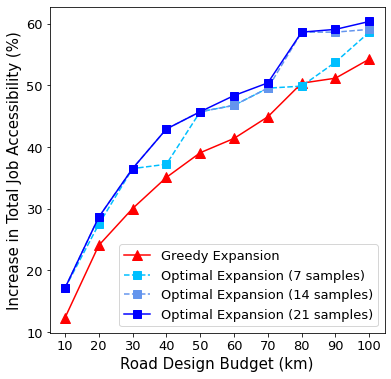

In [10]:
# set params
sidx, eidx, p = 0, 50, 500
budgets = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
greedy_opt(budgets=budgets, sidx=sidx, eidx=eidx, p=p)